# Homework: Word Embedding

In this exercise, you will work on the skip-gram neural network architecture for Word2Vec. You will be using Keras to train your model. 

You must complete the following tasks:
1. Read/clean text files
2. Indexing (Assign a number to each word)
3. Create skip-grams (inputs for your model)
4. Create the skip-gram neural network model
5. Visualization
6. Evaluation (Using pre-trained, not using pre-trained)
    (classify topic from 4 categories) 
    
This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.



In [1]:
%cd /content/drive/MyDrive/gggg

/content/drive/MyDrive/gggg


In [2]:
%mkdir test

mkdir: cannot create directory ‘test’: File exists


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%tensorflow_version 2.x
%matplotlib inline
import numpy as np
import pandas as pd
import math
import glob
import re
import random
import collections
import os
import sys
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense, Masking, Conv1D, Bidirectional
from tensorflow.python.keras.layers.merge import Dot
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

random.seed(42)

# Step 1: Read/clean text files

The given code can be used to processed the pre-tokenzied text file from the wikipedia corpus. In your homework, you must replace those text files with raw text files.  You must use your own tokenizer to process your text files

In [ ]:
!wget https://www.dropbox.com/s/eexden7246sgfzf/BEST-TrainingSet.zip
!wget https://www.dropbox.com/s/n87fiy25f2yc3gt/wiki.zip
!unzip wiki.zip
!unzip BEST-TrainingSet.zip

--2021-02-21 06:26:50--  https://www.dropbox.com/s/eexden7246sgfzf/BEST-TrainingSet.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/eexden7246sgfzf/BEST-TrainingSet.zip [following]
--2021-02-21 06:26:51--  https://www.dropbox.com/s/raw/eexden7246sgfzf/BEST-TrainingSet.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd434c6539f8ecb0a21fe6cf44f.dl.dropboxusercontent.com/cd/0/inline/BJXh7crqm7IedYdH1GtDtXp0cP5aiPRkwhW_2qdMfA-uFSaU5kYp9-x0RK1RMTvJs-kMyCLtpVqWwzguLMi0Q3PsrkdhycTK-6YrKygqgpAjiTXhtX1TLnq0urztbPb_vbE/file# [following]
--2021-02-21 06:26:51--  https://ucd434c6539f8ecb0a21fe6cf44f.dl.dropboxusercontent.com/cd/0/inline/BJXh7crqm7IedYdH1GtDtXp0cP5aiPRkwhW_2qdMfA-uFSaU5kYp9-x0RK1RMTvJs-kMyCLtpVqWwzguLMi0Q3P

In [5]:
#Step 1: read the wikipedia text file
with open("wiki/thwiki_chk.txt") as f:
    #the delimiter is one or more whitespace characters
    input_text = re.compile(r"\s+").split(f.read()) 
    #exclude an empty string from our input
    input_text = [word for word in input_text if word != ''] 

In [6]:
tokens = input_text
print(tokens[:10])
print("total word count:", len(tokens))

['หน้า', 'หลัก', 'วิกิพีเดีย', 'ดำเนินการ', 'โดย', 'มูลนิธิ', 'วิกิ', 'มีเดีย', 'องค์กร', 'ไม่']
total word count: 36349066


# Step 2: Indexing (Assign a number to each word)

The code below generates an indexed dataset(each word is represented by a number), a dictionary, a reversed dictionary

## <font color='blue'>Homework Question 1:</font>
<font color='blue'>“UNK” is often used to represent an unknown word (a word which does not exist in your dictionary/training set). You can also represent a rare word with this token as well.  How do you define a rare word in your program? Explain in your own words and capture the screenshot of your code segment that is a part of this process</font>

 + <font color='blue'>edit or replace create_index with your own code to set a threshold for rare words and replace them with "UNK"</font>

Ans: Using data visualization for find a good threshold for cut off rare words so i picked 5 as a threshold that mean all of the word which has less than or equal to threshold will be change into UNK as a process of rareword replacing ( the words which cannot surpass threshould are considered as rare words

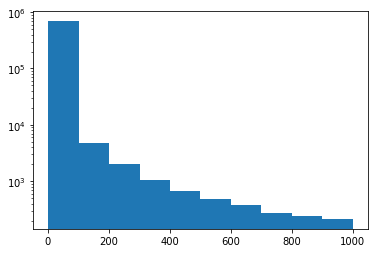

[('ที่', 950006), ('ใน', 897329), ('เป็น', 726847), ('และ', 668116), ('การ', 619128), ('มี', 536738), ('ของ', 532237), ('ได้', 508117), (')', 359576), ('"', 357830)]
36349066
109904


In [7]:
#step 2:Build dictionary and build a dataset(replace each word with its index)

import numpy as np
import matplotlib.pyplot as plt



def create_index(input_text, min_thres_unk = 0, max_word_count = None):
    # TODO#1 : edit or replace this function
    words = [word for word in input_text ]
    word_count = list()

    #use set and len to get the number of unique words
    word_count.extend(collections.Counter(words).most_common(len(set(words))))
    #include a token for unknown word
    unk_count = 0
    state = 0

    
    freq = [e[1] for e in word_count]
  
    plt.hist(freq,  range=[1, 1000])
    plt.yscale('log')

    plt.show()
  
    if min_thres_unk:
      pointer = 0
      for i,c in enumerate(word_count):
        if c[1] <= min_thres_unk:
          unk_count+=1
          state = 1
        elif state  == 0:
          pointer = i


      word_count = word_count[:pointer+1]
    new_word = set([e[0] for e in word_count])



    word_count.append(("UNK",unk_count))
    #print out 10 most frequent words
    print(word_count[0:10])

    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word in word_count:
        dictionary[word[0]] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    data = list()
    for word in input_text:
        if word in new_word:
          data.append(dictionary[word])
        else:
          data.append(dictionary['UNK'])

    return data,dictionary, reverse_dictionary

# call method with min_thres_unk=1ß
dataset, dictionary, reverse_dictionary = create_index(tokens, 5)
print(len(dataset))
print(len(dictionary))

In [8]:
print("output sample (dataset):",dataset[:10])
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:10]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:10]})

output sample (dataset): [229, 208, 2453, 573, 15, 1829, 7149, 3124, 681, 24]
output sample (dictionary): {'for_keras_zero_padding': 0, 'ที่': 1, 'ใน': 2, 'เป็น': 3, 'และ': 4, 'การ': 5, 'มี': 6, 'ของ': 7, 'ได้': 8, ')': 9}
output sample (reverse dictionary): {0: 'for_keras_zero_padding', 1: 'ที่', 2: 'ใน', 3: 'เป็น', 4: 'และ', 5: 'การ', 6: 'มี', 7: 'ของ', 8: 'ได้', 9: ')'}


# Step3: Create skip-grams (inputs for your model)
Keras has a skipgrams-generator, the cell below shows us how it generates skipgrams 

## <font color='blue'>Homework Question 2:</font>
<font color='blue'>The negative samples are sampled from sampling_table.  Look through Keras source code to find out how they sample negative samples. Discuss the sampling technique taught in class and compare it to the Keras source code.</font>



Ans: a difference is apoches of probablility-normalization. In class the prob was normalized by power with factional number but keras use this equation: p(word) = (min(1, sqrt(word_frequency / sampling_factor) /
 (word_frequency / sampling_factor)))

<font color='red'>Q2: PUT YOUR ANSER HERE!!!</font>

In [9]:
# Step 3: Create data samples
vocab_size = len(dictionary)
skip_window = 1       # How many words to consider left and right.

# TODO#2 check out keras source code and find out how their sampling technique works. Describe it in your own words.
sample_set= dataset[:10]
sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples, labels)

for i in range(8):
    print(reverse_dictionary[couples[i][0]],reverse_dictionary[couples[i][1]])



[[3124, 7149], [3124, 93851], [3124, 54988], [2453, 85182], [208, 229], [3124, 681], [2453, 573], [24, 28894], [24, 681], [208, 2453], [2453, 91925], [208, 58879], [208, 71427], [2453, 208]] [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]
มีเดีย วิกิ
มีเดีย พระสาโรชรั
มีเดีย ไชลด์
วิกิพีเดีย ควิเบกแอร์เพล
หลัก หน้า
มีเดีย องค์กร
วิกิพีเดีย ดำเนินการ
ไม่ เกิดพันธะ


# Step 4: create the skip-gram model
## <font color='blue'>Homework Question 3:</font>
 <font color='blue'>Q3:  In your own words, discuss why Sigmoid is chosen as the activation function in the  skip-gram model.</font>

ANS: Because sigmoid is a good choice of calculate in term of probablility and has a simple term when it's taken diff and the range of value is between 0,1 so it can avoid exploding vanishing gadient

<font color='red'>Q3: PUT YOUR ANSER HERE!!!</font>

In [10]:
#reference: https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb
dim_embedddings = 32
V= len(dictionary)

#step1: select the embedding of the target word from W
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V+1, dim_embedddings)(w_inputs)

#step2: select the embedding of the context word from C
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V+1, dim_embedddings)(c_inputs)

#step3: compute the dot product:c_k*v_j
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)

#step4: normailize dot products into probability
o = Activation('sigmoid')(o)
#TO DO#4 Question: Why sigmoid?

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
opt=Adam(lr=0.01)
SkipGram.compile(loss='binary_crossentropy', optimizer=opt)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        3516960     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 32)        3516960     input_2[0][0]                    
______________________________________________________________________________________________

In [50]:
len(dataset)

36349066

In [ ]:
# you don't have to spend too much time training for your homework, you are allowed to do it on a smaller corpus
# currently the dataset is 1/20 of the full text file.
for _ in range(1):
    prev_i=0
    print(prev_i)
    #it is likely that your GPU won't be able to handle large input
    #just do it 100000 words at a time
    for i in range(len(dataset)//100000):
        #generate skipgrams
        data, labels = skipgrams(sequence=dataset[prev_i*100000:(i*100000)+100000], vocabulary_size=V, window_size=2, negative_samples=4.)
        x = [np.array(x) for x in zip(*data)]
        y = np.array(labels, dtype=np.int32)
        if x:
            loss = SkipGram.train_on_batch(x, y)
        prev_i = i 
        print(loss,i*100000)


In [ ]:
SkipGram.save_weights('my_skipgram32_weights-hw.h5')

In [60]:
## I restarted my session so this weights come from previous session training ( 1 eporch)
SkipGram.load_weights('my_skipgram32_weights-hw.h5')

In [61]:
#Get weight of the embedding layer
final_embeddings=SkipGram.get_weights()[0]
print(final_embeddings)
print(final_embeddings.shape)

[[ 0.03217584 -0.00633525  0.04837986 ... -0.01650785 -0.04674113
   0.03138161]
 [ 0.53025055  0.47032288  0.4194459  ... -0.10992594 -0.45043236
   0.38256776]
 [ 0.42733765  0.4445961   0.5103343  ... -0.05750939 -0.50145453
   0.44299632]
 ...
 [ 0.04131928  0.04237149  0.01988628 ...  0.04836312  0.01234924
  -0.02553778]
 [ 0.41542163  0.42954892  0.37651753 ... -0.42746246 -0.42733023
   0.502051  ]
 [-0.00815544  0.04571868 -0.03131225 ...  0.00713114  0.00218074
   0.02337874]]
(109905, 32)


In [ ]:
dictionary

# Step 5: Intrinsic Evaluation: Word Vector Analogies
## <font color='blue'>Homework Question 4: </font>
<font color='blue'> Read section 2.1 and 2.3 in this [lecture note](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes02-wordvecs2.pdf). Come up with 10 semantic analogy examples and report results produced by your word embeddings </font>


In [106]:
# TODO#4:Come up with 10 semantic analogy examples and report results produced by your word embeddings 
#and tell us what you observe
import scipy
import scipy.spatial
s = [ ['นก','ไก่','คน' ] , ['พยายาม','หนี','ขยัน'],['คน','ชีวิต','ตาย'],['ปลา','น้ำ','นภา'],['นรก','บาป','บุญ'],['บอล','กีฬา','หมา'],['หนาว','เย็น','ไฟ'],['เพื่อน','แอบ','ชอบ'],['ไทย', 
'อาเซียน','อังกฤษ'],['คอม','ไฟ','กระดาษ'],['ทหาร','เผด็จการ','ประชาธิปไตย']]
for i in s:
  
  new_word_vec = (final_embeddings[dictionary[i[0]]]-final_embeddings[dictionary[i[1]]]+final_embeddings[dictionary[i[2]]]).reshape(1,-1)
  distance = scipy.spatial.distance.cdist(final_embeddings, new_word_vec, 'cosine').reshape(-1)
  index = np.argpartition(distance,1)[:1][0]
  print(i[0],'-',i[1],'+',i[2],'=',reverse_dictionary[index])


นก - ไก่ + คน = สกุล
พยายาม - หนี + ขยัน = พฤติกรรม
คน - ชีวิต + ตาย = Phantom
ปลา - น้ำ + นภา = ออฟ
นรก - บาป + บุญ = รู
บอล - กีฬา + หมา = นะ
หนาว - เย็น + ไฟ = อตุ
เพื่อน - แอบ + ชอบ = อะไร
ไทย - อาเซียน + อังกฤษ = สมาคม
คอม - ไฟ + กระดาษ = เลิศ
ทหาร - เผด็จการ + ประชาธิปไตย = ประชาชน


# Step 6: Extrinsic Evaluation

## <font color='blue'>Homework Question5:</font>
<font color='blue'>
Use the word embeddings from the skip-gram model as pre-trained weights in a classification model. Compare the result the with the same classification model that does not use the pre-trained weights. 
</font>


In [53]:
all_news_filepath = glob.glob('BEST-TrainingSet/news/*.txt')
all_novel_filepath = glob.glob('BEST-TrainingSet/novel/*.txt')
all_article_filepath = glob.glob('BEST-TrainingSet/article/*.txt')
all_encyclopedia_filepath = glob.glob('BEST-TrainingSet/encyclopedia/*.txt')

In [54]:
#preparing data for the classificaiton model
#In your homework, we will only use the first 2000 words in each text file
#any text file that has less than 2000 words will be padded
#reason:just to make this homework feasible under limited time and resource
max_length = 2000
def word_to_index(word):
    if word in dictionary:
        return dictionary[word]
    else:#if unknown
        return dictionary["UNK"]


def prep_data():
    input_text = list()
    for textfile_path in [all_news_filepath, all_novel_filepath, all_article_filepath, all_encyclopedia_filepath]:
        for input_file in textfile_path:
            f = open(input_file,"r") #open file with name of "*.txt"
            text = re.sub(r'\|', ' ', f.read()) # replace separation symbol with white space           
            text = re.sub(r'<\W?\w+>', '', text)# remove <NE> </NE> <AB> </AB> tags
            text = text.split() #split() method without an argument splits on whitespace 
            indexed_text = list(map(lambda x:word_to_index(x), text[:max_length])) #map raw word string to its index   
            if 'news' in input_file:
                input_text.append([indexed_text,0]) 
            elif 'novel' in input_file:
                input_text.append([indexed_text,1]) 
            elif 'article' in input_file:
                input_text.append([indexed_text,2]) 
            elif 'encyclopedia' in input_file:
                input_text.append([indexed_text,3]) 
            
            f.close()
    random.shuffle(input_text)
    return input_text

input_data = prep_data()
train_data = input_data[:int(len(input_data)*0.6)]
val_data = input_data[int(len(input_data)*0.6):int(len(input_data)*0.8)]
test_data = input_data[int(len(input_data)*0.8):]

train_input = [data[0] for data in train_data]
train_input = sequence.pad_sequences(train_input, maxlen=max_length) #padding
train_target = [data[1] for data in train_data]
train_target=to_categorical(train_target, num_classes=4)

val_input = [data[0] for data in val_data]
val_input = sequence.pad_sequences(val_input, maxlen=max_length) #padding
val_target = [data[1] for data in val_data]
val_target=to_categorical(val_target, num_classes=4)

test_input = [data[0] for data in test_data]
test_input = sequence.pad_sequences(test_input, maxlen=max_length) #padding
test_target = [data[1] for data in test_data]
test_target=to_categorical(test_target, num_classes=4)

del input_data, val_data,train_data, test_data

In [55]:
#the classification model
#TODO#5 find out how to initialize your embedding layer with pre-trained weights, evaluate and observe
#don't forget to compare it with the same model that does not use pre-trained weights
#you can use your own model too! and feel free to customize this model as you wish
cls_model = Sequential()
cls_model.add(Embedding(len(dictionary)+1, 32, input_length=max_length,mask_zero=True))
cls_model.add(GRU(32))
cls_model.add(Dropout(0.5))
cls_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model.summary()
print('Train...')
cls_model.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 32)          3516960   
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 3,523,428
Trainable params: 3,523,428
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/10
10/10 [==============================] - 33s 3s/step - loss: 1.3688 - accuracy: 0.3216 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 26s 3s/step - loss: 1.2448 - accura

In [56]:
results = cls_model.evaluate(test_input, test_target)
print("test loss, test acc:", results)

4/4 [==============================] - 2s 110ms/step - loss: 2.8888 - accuracy: 0.4314
test loss, test acc: [2.888795852661133, 0.4313725531101227]


In [104]:
cls_model_with_init = Sequential()
cls_model_with_init.add(Embedding(len(dictionary)+1, 32, input_length=max_length,mask_zero=True,weights=[final_embeddings]))
cls_model_with_init.add(GRU(32))
cls_model_with_init.add(Dropout(0.5))
cls_model_with_init.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model_with_init.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model_with_init.summary()
print('Train...')
cls_model_with_init.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 32)          3516960   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 3,523,428
Trainable params: 3,523,428
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/10
10/10 [==============================] - 31s 3s/step - loss: 1.4372 - accuracy: 0.2932 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 26s 2s/step - loss: 1.2926 - accu

In [105]:
results_with_init = cls_model_with_init.evaluate(test_input, test_target)
print("without init:test loss, test acc:", results)
print("with init test loss, test acc:", results_with_init)

4/4 [==============================] - 2s 110ms/step - loss: 1.8717 - accuracy: 0.4804
without init:test loss, test acc: [2.888795852661133, 0.4313725531101227]
with init test loss, test acc: [1.8716546297073364, 0.4803921580314636]
